In [1]:
# dependencies
import os
from tqdm import tqdm
import time
import datetime
import dateutil
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import APIs
from Keys.NYTAPI import nyt_api
from Keys.NewsAPI import news_api
from Keys.AlphaAPI import alpha_api

In [2]:
%matplotlib notebook

In [3]:
# make api_keys global vars so that functions can use them
def set_api_global():
    global nyt_api
    global news_api
    global alpha_api

set_api_global()

# Topic & Stock_Quote

In [4]:
Topic = "Apple"
Stock_Quote = "AAPL"

# make the key_word global
def set_topicstockquote_global():
    global Topic
    global Stock_Quote

set_topicstockquote_global()

# Stock Data

## 1) Define a function that returns a stock dataframe

In [5]:
def get_stock_data(stock_quote, stock_dates):
    stock_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock_quote+"&apikey="+alpha_api
    open_prices = []
    volumes = []
    dates_output = []
    
    data = requests.get(stock_url).json()
    
    for stock_date in tqdm(stock_dates):
        # There are holidays and weekends
        try:
            open_prices.append(data["Time Series (Daily)"][stock_date]["1. open"])
            volumes.append(data["Time Series (Daily)"][stock_date]["5. volume"])
            if stock_date in data["Time Series (Daily)"].keys():
                dates_output.append(stock_date)
        except:
            pass
    
    stock_df = pd.DataFrame({"Date": dates_output, 
                             stock_quote+" Open Price": pd.to_numeric(open_prices), 
                             stock_quote+" Volume": pd.to_numeric(volumes)
                            })
    return stock_df, dates_output

## 2) Inputs

In [6]:
# set stock_dates
stock_dates = []

# decide the start date
start_date = datetime.date(2018,6,1)
number_of_days = 91

for i in range(number_of_days):
    stock_date = start_date + datetime.timedelta(i)
    stock_dates.append(stock_date.isoformat())

## 3) Get the stock dataframes

In [7]:
stock_df, stock_dates_output = get_stock_data(Stock_Quote, stock_dates)

100%|██████████| 91/91 [00:00<00:00, 125842.95it/s]


## 4) Save to csv

In [8]:
stock_df.to_csv(os.path.join(".", Topic, Stock_Quote+"_"+"open price & volume.csv"))

# News Data

## 1) Extract data from New York Times

In [9]:
# build a function that transfer the ISO formatted string back to datetime
def getDataTimeFromISO(iso):
    d = dateutil.parser.parse(iso)
    return d

In [10]:
getDataTimeFromISO(stock_dates_output[0])

datetime.datetime(2018, 6, 1, 0, 0)

In [11]:
# define the day_lag variable. -1 means the news yesterday may determines the price today.
day_lag = -1
# change the date
bd = getDataTimeFromISO(stock_dates_output[0]).date()+datetime.timedelta(day_lag)
# the params works in a way that does not include the end date. Therefore we need one more day from the end date
ed = getDataTimeFromISO(stock_dates_output[-1]).date()+datetime.timedelta(day_lag+1)

In [12]:
bd = bd.isoformat()
ed = ed.isoformat()

In [13]:
begin_date = bd[:4] + bd[5:7] + bd[8:10]
end_date = ed[:4] + ed[5:7] + ed[8:10]
print(begin_date, end_date)

20180531 20180830


In [14]:
# make bd, ed global
def set_date_global():
    global bd
    global ed
    global day_lag

set_date_global()

In [15]:
# prepare variables
# make sure we can loop through all the articles we get
n = 500
pages = range(n)
nyt_snippet = []
nyt_pub_date = []

# urls
nyt_base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# get data from urls
for page in tqdm(pages):
    params = {
        "api-key": nyt_api,
        "q": Topic,
        "begin_date": begin_date,
        "end_date": end_date,
        "sort": "newest",
        "fl": ["snippet","pub_date"],
        "page": page
    }
    # pause to avoid being classified as spam
    # time.sleep(0.2)
    
    try: 
        nyt_data = requests.get(nyt_base_url, params=params).json()
        # loop through 10 articles on each page
        for i in range(10):
            nyt_snippet.append(nyt_data["response"]["docs"][i]["snippet"])
            interm_date = nyt_data["response"]["docs"][i]["pub_date"]
            nyt_pub_date.append(interm_date[:4]+interm_date[5:7]+interm_date[8:10])
   
    except:
        pass

100%|██████████| 500/500 [01:55<00:00,  4.32it/s]


## 2) Save The New York Times data to csv

In [16]:
nyt_news_df = pd.DataFrame({"Date": nyt_pub_date, "Snippet": nyt_snippet})
nyt_news_df.to_csv(os.path.join(".", Topic, "New York Times.csv"))

## 3) Extract Data from News API - WSJ, FOX, CNN

### note the pages!

In [17]:
def newsAPI(news_input):
    base_url = "https://newsapi.org/v2/everything"
    description = []
    pub_date = []
    pageSize = 100
    pages = range(20)
    
    if news_input == "WSJ":
        news_source = "the-wall-street-journal"
    elif news_input == "CNN":
        news_source = "cnn"
    elif news_input == "FOX":
        news_source = "fox-news"
    
    for page in tqdm(pages):
        params = {
            "q": Topic,
            "sources": news_source,
            "apiKey": news_api,
            "from": bd,
            # due to the different params functions, change the end date here to match the dates in New York Times
            "to": (getDataTimeFromISO(ed)+datetime.timedelta(-1)).date().isoformat(),
            "pageSize": pageSize,
            "page": page,
            "sortBy": "publishedAt"
        }
        # pause to avoid being classified as spam
        time.sleep(0.2)
        
        try:
            data = requests.get(base_url, params=params).json()
            # loop through each article on each page
            for i in range(pageSize):
                description.append(data["articles"][i]["description"])
                pub_date.append(data["articles"][i]["publishedAt"][:10])
        except:
            pass
    
    return description, pub_date

In [18]:
wsj_description, wsj_pub_date = newsAPI("WSJ")

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [19]:
cnn_description, cnn_pub_date = newsAPI("CNN")

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


## 4) Save Data from News API - WSJ, CNN

### Please Note: FOX has been taken out because it does not have much data points

In [20]:
wsj_news_df = pd.DataFrame({"Date": wsj_pub_date, "Description": wsj_description})
wsj_news_df.to_csv(os.path.join(".", Topic, "WSJ.csv"))

In [21]:
cnn_news_df = pd.DataFrame({"Date": cnn_pub_date, "Description": cnn_description})
cnn_news_df.to_csv(os.path.join(".", Topic, "CNN.csv"))

# Vader Sentiment Score

## 1) Get vader scores from news data

In [22]:
# define a function to recycle the code
def vaderSentimentScoreCalculator(dates, sentences):
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = []
    news_dates = []
    for date, sentence in zip(dates, sentences):
        try: 
            vs = analyzer.polarity_scores(sentence)
            vader_scores.append(vs['compound'])
            news_dates.append(date)
        except:
            pass
    
    return news_dates, vader_scores

In [23]:
nyt_dates, nyt_vaderscores = vaderSentimentScoreCalculator(nyt_pub_date, nyt_snippet)
wsj_dates, wsj_vaderscores = vaderSentimentScoreCalculator(wsj_pub_date, wsj_description)
cnn_dates, cnn_vaderscores = vaderSentimentScoreCalculator(cnn_pub_date, cnn_description)

## 2) Set up dataframe for vader score

In [24]:
def news_to_vaderscore(news_source, pub_date, vadercores):
    
    news_dates = []
    
    for d in pub_date:
        d = getDataTimeFromISO(d).date() - datetime.timedelta(day_lag)
        d = d.isoformat()
        news_dates.append(d)
    
    news_df = pd.DataFrame({"Date": news_dates, news_source+" VS (Day_Lag="+str(day_lag)+")": vadercores})
    
    grouped_news_df = news_df.groupby("Date")
    
    adjusted_news_df = pd.DataFrame({
        "Date": grouped_news_df.count().index,
        news_source+" VS (Day_Lag="+str(day_lag)+")": grouped_news_df[news_source+" VS (Day_Lag="+str(day_lag)+")"].mean()
        })
    
    # format the vader score
    adjusted_news_df[news_source+" VS (Day_Lag="+str(day_lag)+")"] = adjusted_news_df[news_source+" VS (Day_Lag="+str(day_lag)+")"].map("{:.4f}".format)
    
    # convert vader score to numeric
    adjusted_news_df[news_source+" VS (Day_Lag="+str(day_lag)+")"] = pd.to_numeric(adjusted_news_df[news_source+" VS (Day_Lag="+str(day_lag)+")"])
    
    return adjusted_news_df

In [25]:
nyt_df = news_to_vaderscore("NYT", nyt_dates, nyt_vaderscores)
wsj_df = news_to_vaderscore("WSJ", wsj_dates, wsj_vaderscores)
cnn_df = news_to_vaderscore("CNN", cnn_dates, cnn_vaderscores)

## 3) Save to csv

In [26]:
nyt_df.to_csv(os.path.join(".", Topic, "nyt_vs.csv"))
wsj_df.to_csv(os.path.join(".", Topic, "wsj_vs.csv"))
cnn_df.to_csv(os.path.join(".", Topic, "cnn_vs.csv"))

# Merge stock dataframes and vader score dataframes

In [27]:
nyt_wsj_df = nyt_df.merge(wsj_df, how="inner", on="Date")

/Users/apple/Documents/anaconda3/envs/PyData/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [28]:
nyt_wsj_cnn_df = nyt_wsj_df.merge(cnn_df, how="inner", on="Date")

/Users/apple/Documents/anaconda3/envs/PyData/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [29]:
stock_news_df = stock_df.merge(nyt_wsj_cnn_df, how="inner", on="Date")

# Output Dataframe

In [30]:
stock_news_df.to_csv(os.path.join(".", Topic, Topic+"_"+"final.csv"))

In [31]:
stock_news_df.columns

Index(['Date', 'AAPL Open Price', 'AAPL Volume', 'NYT VS (Day_Lag=-1)',
       'WSJ VS (Day_Lag=-1)', 'CNN VS (Day_Lag=-1)'],
      dtype='object')

<IPython.core.display.Javascript object>


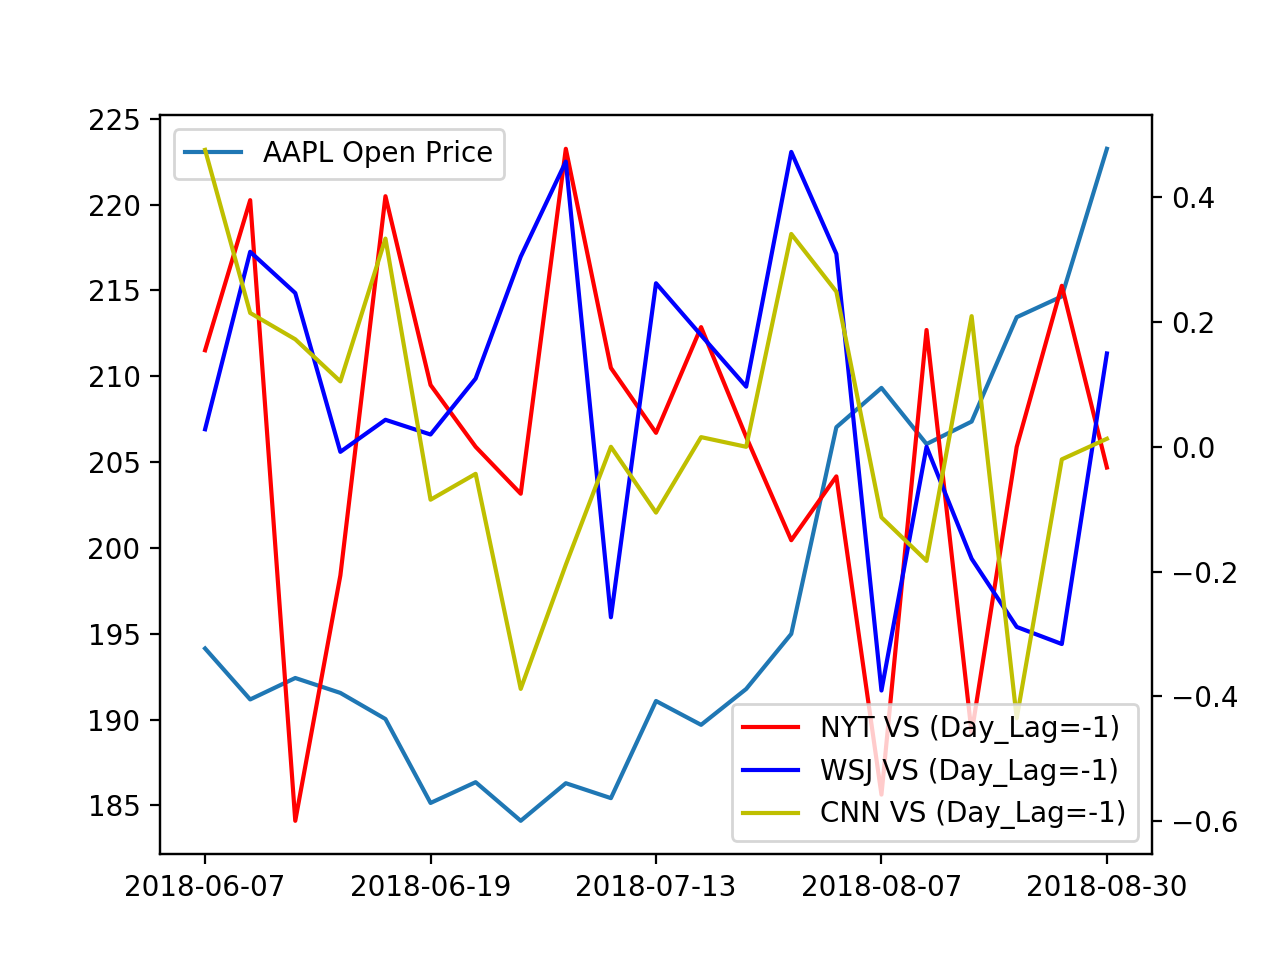

([<matplotlib.axis.XTick at 0x121648e10>,
 <a list of 5 Text xticklabel objects>)

In [32]:
fig, ax1 = plt.subplots()

x_axis = stock_news_df["Date"]

ax1.plot(x_axis, stock_news_df[Stock_Quote+" Open Price"])

ax2 = ax1.twinx()
ax2.plot(x_axis, stock_news_df['NYT VS (Day_Lag=-1)'], color="r")
ax2.plot(x_axis, stock_news_df['WSJ VS (Day_Lag=-1)'], color="b")
ax2.plot(x_axis, stock_news_df['CNN VS (Day_Lag=-1)'], color="y")

ax1.legend(loc="upper left")
ax2.legend(loc="lower right")

plt.xticks(np.arange(0, len(stock_news_df[Stock_Quote+" Open Price"]-1), 5))